In [47]:
%pylab inline
import emcee

import os
import sys
from __future__ import print_function, division
import corner
from astropy.constants import au,h,pc,c
from hitranmaster import hitran
from cvs.cvsutils import wn_to_k
import json
import glob
import pickle
import pdb as pdb
from slabspec import make_spec
from cvs.cvsmodels import linespec_co

Populating the interactive namespace from numpy and matplotlib


/Users/csalyk/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['amin', 'amax']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Goal of this notebook is to try running MCMC to find Temperature, Column Density and Emitting Area for a dataset, using an LTE model.

Steps:

-Try running a simple MCMC example - done!

-Try running MCMC on synthetic data with an optically thin model - done!

-Try running MCMC on real data with an optically thin model - done!

-Try running MCMC with an optically thick model

## Example model to use as template for my own models

In [108]:
#Content of createdata.py
"""                                                                                           
Set up a model and data                                                                        
"""
# set the true values of the model parameters for creating the data                           
m = 3.5 # gradient of the line                                                                
c = 1.2 # y-intercept of the line                                                             

# set the "predictor variable"/abscissa                                                       
M = 100
xmin = 0.
xmax = 10.
stepsize = (xmax-xmin)/M
x = np.arange(xmin, xmax, stepsize)

# define the model function                                                                   
def straight_line(x, m, c):
    """                                                                                       
    A straight line model: y = m*x + c                                                        
                                                                                              
    Args:                                                                                     
        x (list): a set of abscissa points at which the model is defined                      
        m (float): the gradient of the line                                                   
        c (float): the y-intercept of the line                                                
    """

    return m*x + c

# create the data - the model plus Gaussian noise                                             
sigma = 0.5 # standard deviation of the noise                                                 
data = straight_line(x, m, c) + sigma*np.random.randn(M)

In [109]:
#Define prior, likelihood, posterior
"""                                                                                           
Example of running emcee to fit the parameters of a straight line.                            
"""
#Define log of posterior. Posterior is prior x likelihood, 
#so log posterior is log prior + log likelihood
def logposterior(theta, data, sigma, x):
    """                                                                                       
    The natural logarithm of the joint posterior.                                             
                                                                                              
    Args:                                                                                     
        theta (tuple): a sample containing individual parameter values                        
        data (list): the set of data/observations                                             
        sigma (float): the standard deviation of the data points                              
        x (list): the abscissa values at which the data/model is defined                      
    """

    lp = logprior(theta) # get the prior                                                      

    # if the prior is not finite return a probability of zero (log probability of -inf)       
    if not np.isfinite(lp):
        return -np.inf

    # return the likeihood times the prior (log likelihood plus the log prior)   
    return lp + loglikelihood(theta, data, sigma, x)

#Define log of likelihood
#What is the probability of getting a particular dataset given model parameters
#and noise level?
def loglikelihood(theta, data, sigma, x):
    """                                                                                       
    The natural logarithm of the joint likelihood.                                            
                                                                                              
    Args:                                                                                     
        theta (tuple): a sample containing individual parameter values                        
        data (list): the set of data/observations                                             
        sigma (float): the standard deviation of the data points                              
        x (list): the abscissa values at which the data/model is defined                                       
    """

    # unpack the model parameters from the tuple                                              
    m, c = theta

    # evaluate the model (assumes that the straight_line model is defined as above)           
    md = straight_line(x, m, c)

    # return the log likelihood                                                               
    return -0.5*np.sum(((md - data)/sigma)**2)

#Define log of prior function.  What are the allowed values of the parameters?
#This example assumes a uniform prior for constant, going from -10 to 10
#This example assumes a Gaussian prior for slope, 

def logprior(theta):
    """                                                                                       
    The natural logarithm of the prior probability.                                           
                                                                                              
    Args:                                                                                     
        theta (tuple): a sample containing individual parameter values                                                         
    """

    lp = 0.

    # unpack the model parameters from the tuple                                              
    m, c = theta

    # uniform prior on c                                                                      
    cmin = -10. # lower range of prior                                                        
    cmax = 10.  # upper range of prior                                                        

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range       
    lp = 0. if cmin < c < cmax else -np.inf

    # Gaussian prior on m                                                                     
    mmu = 0.     # mean of the Gaussian prior                                                 
    msigma = 10. # standard deviation of the Gaussian prior                                   
    lp -= 0.5*((m - mmu)/msigma)**2   #Add log prior due to mean to lp due to constant.

    return lp

In [110]:
Nens = 100   # number of ensemble points                                                         

mmu = 0.     # mean of the Gaussian prior                                                        
msigma = 10. # standard deviation of the Gaussian prior                                          

mini = np.random.normal(mmu, msigma, Nens) # initial m points                                    

cmin = -10.  # lower range of prior                                                              
cmax = 10.   # upper range of prior                                                              

cini = np.random.uniform(cmin, cmax, Nens) # initial c points                                    

inisamples = np.array([mini, cini]).T # initial samples                                          
#100 x 2  (Nens x Nparameters)

ndims = inisamples.shape[1] # number of parameters/dimensions                                    

Nburnin = 500   # number of burn-in samples                                                      
Nsamples = 500  # number of final posterior samples                                              

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)        
argslist = (data, sigma, x)

# set up the sampler                                                                             
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

# pass the initial samples and total number of samples required                                  
sampler.run_mcmc(inisamples, Nsamples+Nburnin);

Number of posterior samples is 50000


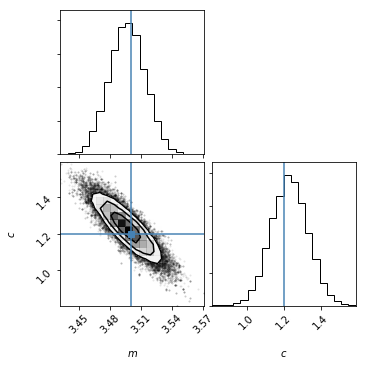

In [114]:
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

print('Number of posterior samples is {}'.format(postsamples.shape[0]))

fig = corner.corner(postsamples, labels=[r"$m$", r"$c$"], truths=[m, c])

## Optically thin rotation diagram model
## Try first with synthetic dataset

In [33]:
#Get 12CO HITRAN data
hitran_data, __ =hitran.extract_data('CO', 4.64,5.1, eupmax=10000, aupmin=0.005, isot=1)
w0=np.array(1e4/hitran_data['linecenter'])
vup =np.array([np.int(vp) for vp in hitran_data['Vp']])
vlow =np.array([np.int(vpp) for vpp in hitran_data['Vpp']])
aup=np.array(hitran_data['Acoeff'])
gup=np.array(hitran_data['gp'])
tup=np.array(wn_to_k((hitran_data['Epp']+hitran_data['linecenter'])))

vbool=((vup==1) & (vlow==0))
w0=w0[vbool]
vup=vup[vbool]
vlow=vlow[vbool]
aup=aup[vbool]
gup=gup[vbool]
tup=tup[vbool]

w0=np.flip(w0,0)
vup=np.flip(vup,0)
vlow=np.flip(vlow,0)
aup=np.flip(aup,0)
gup=np.flip(gup,0)
tup=np.flip(tup,0)

Reading "/Users/csalyk/mypy/hitranmaster/par/05_hit12.par" ...


In [282]:
#Content of createdata.py
"""                                                                                           
Set up a model and data                                                                        
"""
# set the true values of the model parameters for creating the test dataset                           
temp = 800 # Kelvin                                                                
logntot= 45. #Number of molecules

# set the "predictor variable"       
linenums=np.arange(np.size(tup))

# define the model function                                                                   
def line_flux(linenum, logntot, temp, dist=140.):
    linenum=linenum.astype(int)
    from astropy.constants import h,au,pc,c
    """                                                                                       
    An optically thin LTE model                                                        
                                                                                              
    Args:                                                                                     
        linenum (list): a set of abscissa points at which the model is defined                      
        logntot (float): log of the number of molecules                                                  
        temp (float): the temperature                                               
    """

    w0=np.array([4.64124219, 4.64931172, 4.65748592, 4.6741507,  4.68264278, 4.69124215, 
                 4.69994958, 4.70876567,
                 4.71769101, 4.72672666, 4.73587325, 4.7451314,  4.754502,   4.76398572,
                 4.77358345, 4.78329589, 4.79312421, 4.80306889, 4.81313091, 4.82331102,
                 4.83361045, 4.84402975, 4.85456995, 4.86523233, 4.87601727, 4.88692606,
                 4.89795982, 4.90911919, 4.92040555, 4.93181981, 4.9433629,  4.95503602,
                 4.96684038, 4.97877697, 4.99084704, 5.00305161, 5.01539174, 5.02786897,
                 5.04048441, 5.05323941, 5.06613484, 5.07917236, 5.09235313])
    gup=np.array([7.,  5.,  3. , 1. , 3. , 5. , 7. , 9. ,11. ,13., 15., 17., 19., 21., 23. ,
                  25., 27.,
                  29., 31., 33., 35. ,37. ,39. ,41., 43., 45. ,47., 49., 51., 53., 55., 57.,
                  59. ,61., 63., 65. ,67., 69., 71. ,73. ,75., 77., 79.])
    tup=np.array([3116.57965271, 3100.13500307, 3089.17166351, 3083.68992179, 3089.17180739, 
                  3100.13514695, 3116.57950884,
                  3138.5046053,  3165.90928531, 3198.79254173, 3237.15322354, 3280.9896042,
                  3330.30024494, 3385.08327534, 3445.33639336, 3511.05744084, 3582.24354022,
                  3658.89238946, 3741.00067937, 3828.56567626, 3921.58349546, 4020.05082775,
                  4123.96393233, 4233.31849287, 4348.11076853, 4468.33586748, 4593.98932951,
                  4725.06640666, 4861.56191931, 5003.47054401, 5150.78710115, 5303.50554786,
                  5461.62012903, 5625.12480181, 5794.01309169, 5968.27852418, 6147.91462477,
                  6332.91419958, 6523.27005472, 6718.97485243, 6920.02139882, 7126.40134899,
                  7338.10722129])
    aup=np.array([15.17, 14.08, 11.67, 34.61, 22.95, 20.54, 19.45, 18.8,  18.35, 18.01, 17.74, 
                  17.5,  17.3,
                  17.11, 16.94, 16.78, 16.63, 16.48, 16.35, 16.21, 16.08, 15.96, 15.84, 15.71,
                  15.59, 15.47, 15.36, 15.24, 15.13, 15.02, 14.9,  14.79, 14.68, 14.57, 14.46,
                  14.35, 14.25, 14.14, 14.03, 13.93, 13.82, 13.72, 13.61])           
    nu=c.value/(w0*1e-6)
    ntot=10.**(logntot)            
    q=-3.5179e+02 + 2.7793*temp -3.6737e-03*(temp**2.)+4.0901e-06*(temp**3.)
    
    lineflux=ntot*gup[linenum]*h.value*nu[linenum]*aup[linenum]/(q*4*np.pi*(dist*pc.value)**2)*np.exp(-tup[linenum]/temp)
#mks =W/m^2 =  10^7 erg/m^2 = 10^3 erg/cm^2
    return lineflux

# create the data - the model plus Gaussian noise                                             
sigma=5e-17  #Constant noise level, though may not be realistic.
data=line_flux(linenums,logntot,temp)+sigma*np.random.randn(np.size(linenums))                 

In [283]:
#Define prior, likelihood, posterior
#Define log of posterior. Posterior is prior x likelihood, 
#so log posterior is log prior + log likelihood
def logposterior(theta, data, sigma, linenum):
    """                                                                                       
    The natural logarithm of the joint posterior.                                             
                                                                                              
    Args:                                                                                     
        theta (tuple): a sample containing individual parameter values                        
        data (list): the set of data/observations                                             
        sigma (float): the standard deviation of the data points                              
        x (list): the abscissa values at which the data/model is defined                      
    """

    lp = logprior(theta) # get the prior                                                      

    # if the prior is not finite return a probability of zero (log probability of -inf)       
    if not np.isfinite(lp):
        return -np.inf

    # return the likeihood times the prior (log likelihood plus the log prior)   
    return lp + loglikelihood(theta, data, sigma, linenum)


def logprior(theta):
    """                                                                                       
    The natural logarithm of the prior probability.                                           
                                                                                              
    Args:                                                                                     
        theta (tuple): a sample containing individual parameter values                                                         
    """

    lp = 0.

    # unpack the model parameters from the tuple                                              
    logntot, temp = theta

    # uniform prior on log of ntot                                                                      
    lognmin = 44.  # lower range of prior                                                        
    lognmax = 47.  # upper range of prior                                                        

    # set prior to 1 (log prior to 0) if in the range and zero (log prior to -inf)
    # outside the range       
    lp = 0. if lognmin < logntot < lognmax else -np.inf

    # Gaussian prior on temp                                                                   
    tmu = 800.     # mean of the Gaussian prior                                                 
    tsigma = 200. # standard deviation of the Gaussian prior                                   
    lp -= 0.5*((temp - tmu)/tsigma)**2   #Add log prior due to mean to lp due to constant.

    # set prior to zero (log prior to -inf) if T<=0       
    if (temp <= 0):
        lp = -np.inf    
    
    return lp

def loglikelihood(theta, data, sigma, linenum):
    """                                                                                       
    The natural logarithm of the joint likelihood.                                            
                                                                                              
    Args:                                                                                     
        theta (tuple): a sample containing individual parameter values                        
        data (list): the set of data/observations                                             
        sigma (float): the standard deviation of the data points                              
        x (list): the abscissa values at which the data/model is defined                                       
    """

    # unpack the model parameters from the tuple                                              
    logntot, temp = theta
    # evaluate the model (assumes that the model is defined above)           
    md = line_flux(linenum, logntot, temp, dist=140.)
    
    # return the log likelihood  
    return -0.5*np.sum(((md - data)/sigma)**2)

In [284]:
Nens = 100   # number of ensemble points                                                         

lognmin = 44 # lower range of prior                                                        
lognmax = 47.  # upper range of prior                                                        

lognini = np.random.uniform(lognmin, lognmax, Nens) # initial logn points                                    

tmu = 800.     # mean of the Gaussian prior                                                 
tsigma = 200. # standard deviation of the Gaussian prior                                   

tini = np.random.normal(tmu, tsigma, Nens) # initial t points                                    
                                                           
inisamples = np.array([lognini, tini]).T # initial samples                                          
#100 x 2  (Nens x Nparameters)

ndims = inisamples.shape[1] # number of parameters/dimensions                                    

Nburnin = 500   # number of burn-in samples                                                      
Nsamples = 1000  # number of final posterior samples                                              
#5000 takes about 1 minute

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)        
argslist = (data, sigma, linenums)

# set up the sampler                                                                             
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

# pass the initial samples and total number of samples required                                  
sampler.run_mcmc(inisamples, Nsamples+Nburnin);

In [1]:
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

print('Number of posterior samples is {}'.format(postsamples.shape[0]))

fig = corner.corner(postsamples, labels=[ r"$\log(n_\mathrm{tot})$",r"Temperature [K]"], 
                    truths=[logntot,temp])
axes = np.array(fig.axes).reshape((2, 2))
ax = axes[1,1]
ax.axvline(830,color="g",linestyle='--')
ax = axes[0,0]
ax.axvline(45.0,color="g",linestyle='--')
fig.save_fig('corner_plot.png')

NameError: name 'sampler' is not defined

## Make rotation diagram of results

/Users/csalyk/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


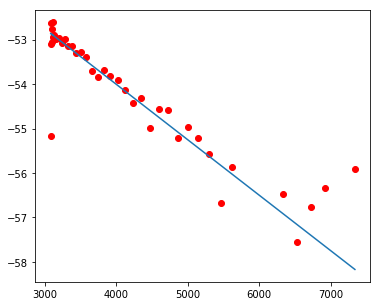

In [292]:
wn=1.e6/w0 #m-1
yrot_data=np.log(data/(wn*gup*aup))
fig=plt.figure(figsize=(6,5))
ax1=fig.add_subplot(111)
ax1.plot(tup,yrot_data,'ro')

flux_model=line_flux(linenums, 45., 800,dist=140.)
yrot_model=np.log(flux_model/(wn*gup*aup))
ax1.plot(tup,yrot_model)

## Try with real dataset

In [342]:
data_dir='/Users/csalyk/Dropbox/LIME/Disk_data/'
pfiles=glob.glob(data_dir+'*.p')
out=pickle.load(open(pfiles[0],'rb'))

linenum_data=[]
for myw0 in out['w0']:
    w=np.where(np.abs(w0-myw0) == np.min(np.abs(w0-myw0)))
    linenum_data.append(w[0][0])
linenum_data=np.array(linenum_data)
flux_data=np.array(out['flux'])*1e-3  #Conversion of cgs to mks
sigma=5.e-18
tup_data=out['tup']
wn_data=out['wn']
gup_data=out['gup']
aup_data=out['aup']
yrot_data=np.log(flux_data/(wn_data*gup_data*aup_data))

In [328]:
Nens = 100   # number of ensemble points                                                         

lognmin = 44 # lower range of prior                                                        
lognmax = 47.  # upper range of prior                                                        

lognini = np.random.uniform(lognmin, lognmax, Nens) # initial logn points                                    

tmu = 800.     # mean of the Gaussian prior                                                 
tsigma = 200. # standard deviation of the Gaussian prior                                   

tini = np.random.normal(tmu, tsigma, Nens) # initial t points                                    
                                                           
inisamples = np.array([lognini, tini]).T # initial samples                                          
#100 x 2  (Nens x Nparameters)

ndims = inisamples.shape[1] # number of parameters/dimensions                                    

Nburnin = 500   # number of burn-in samples                                                      
Nsamples = 1000  # number of final posterior samples                                              
#5000 takes about 1 minute

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)        
argslist = (flux_data, sigma, linenum_data)

# set up the sampler                                                                             
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

# pass the initial samples and total number of samples required                                  
sampler.run_mcmc(inisamples, Nsamples+Nburnin);

Number of posterior samples is 100000


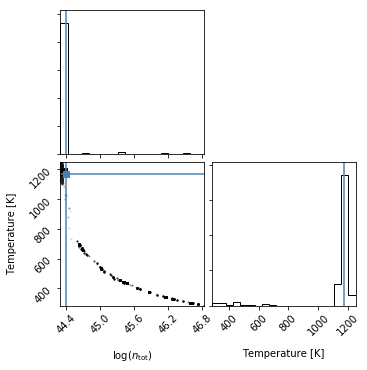

In [335]:
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

print('Number of posterior samples is {}'.format(postsamples.shape[0]))

fig = corner.corner(postsamples, labels=[ r"$\log(n_\mathrm{tot})$",r"Temperature [K]"], 
                    truths=[44.4,1170])

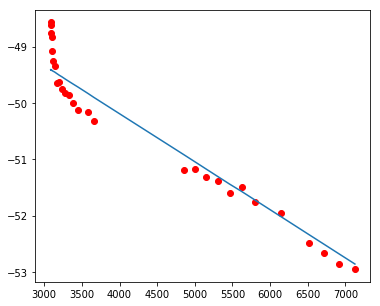

In [343]:
flux_model=line_flux(linenum_data, 44.4, 1170,dist=140.)
yrot_model=np.log(flux_model/(wn_data*gup_data*aup_data))

fig=plt.figure(figsize=(6,5))
ax1=fig.add_subplot(111)
ax1.plot(tup_data,yrot_data,'ro')
ax1.plot(tup_data,yrot_model)

## Tests of optically thick model

In [66]:
#Content of createdata.py
"""                                                                                           
Set up a model and data                                                                        
"""
# set the true values of the model parameters for creating the test dataset                           
temp = 800 # Kelvin                                                                
logntot= 20. #column density (m-2)
area = np.pi*(1.*1.5e11)**2.  #m^2

# set the "predictor variable"       
linenums=np.arange(43)  #Hardcoded.  Number of lines considered in this model.

# define the model function       
def line_flux_optthick(linenum, logntot, temp, area, d_pc=140.):
    linenum=linenum.astype(int)
    from astropy.constants import h,au,pc,c,k_B
    """                                                                                       
    An optically thick LTE model                                                        
                                                                                              
    Args:                                                                                     
        linenum (list): a set of abscissa points at which the model is defined                      
        logntot (float): log of the column density                                                  
        temp (float): the temperature                                               
        area  (float): the emitting area
"""

    w0=np.array([4.64124219, 4.64931172, 4.65748592, 4.6741507,  4.68264278, 4.69124215, 
                 4.69994958, 4.70876567,
                 4.71769101, 4.72672666, 4.73587325, 4.7451314,  4.754502,   4.76398572,
                 4.77358345, 4.78329589, 4.79312421, 4.80306889, 4.81313091, 4.82331102,
                 4.83361045, 4.84402975, 4.85456995, 4.86523233, 4.87601727, 4.88692606,
                 4.89795982, 4.90911919, 4.92040555, 4.93181981, 4.9433629,  4.95503602,
                 4.96684038, 4.97877697, 4.99084704, 5.00305161, 5.01539174, 5.02786897,
                 5.04048441, 5.05323941, 5.06613484, 5.07917236, 5.09235313])
    gup=np.array([7.,  5.,  3. , 1. , 3. , 5. , 7. , 9. ,11. ,13., 15., 17., 19., 21., 23. ,
                  25., 27.,
                  29., 31., 33., 35. ,37. ,39. ,41., 43., 45. ,47., 49., 51., 53., 55., 57.,
                  59. ,61., 63., 65. ,67., 69., 71. ,73. ,75., 77., 79.])
    tup=np.array([3116.57965271, 3100.13500307, 3089.17166351, 3083.68992179, 3089.17180739, 
                  3100.13514695, 3116.57950884,
                  3138.5046053,  3165.90928531, 3198.79254173, 3237.15322354, 3280.9896042,
                  3330.30024494, 3385.08327534, 3445.33639336, 3511.05744084, 3582.24354022,
                  3658.89238946, 3741.00067937, 3828.56567626, 3921.58349546, 4020.05082775,
                  4123.96393233, 4233.31849287, 4348.11076853, 4468.33586748, 4593.98932951,
                  4725.06640666, 4861.56191931, 5003.47054401, 5150.78710115, 5303.50554786,
                  5461.62012903, 5625.12480181, 5794.01309169, 5968.27852418, 6147.91462477,
                  6332.91419958, 6523.27005472, 6718.97485243, 6920.02139882, 7126.40134899,
                  7338.10722129])
    aup=np.array([15.17, 14.08, 11.67, 34.61, 22.95, 20.54, 19.45, 18.8,  18.35, 18.01, 17.74, 
                  17.5,  17.3,
                  17.11, 16.94, 16.78, 16.63, 16.48, 16.35, 16.21, 16.08, 15.96, 15.84, 15.71,
                  15.59, 15.47, 15.36, 15.24, 15.13, 15.02, 14.9,  14.79, 14.68, 14.57, 14.46,
                  14.35, 14.25, 14.14, 14.03, 13.93, 13.82, 13.72, 13.61])           
    nu=c.value/(w0*1e-6)  #frequency
    wn0=1./(w0*1e-6)  #wavenumber, in m-1
    ntot=10.**(logntot)
    eup_freq=k_B.value*tup/h.value
    elow_freq=eup_freq-nu
    tlow=h.value*elow_freq/k_B.value
    
#Define partition function    
    q=0.36288*temp*(1.+np.exp(-3083.7/temp))
#Define intrinsic line width and line shape function
    mu_co=(28.)*1.66e-27
    deltav=np.sqrt(k_B.value*temp/mu_co)   #Not letting user define yet
    phia=1./(deltav*np.sqrt(2.0*np.pi))    #Constant of line shape function
#Define velocity grid
    dvel=1.0e0    #km/s                                                                                                          
    nvel=101
    vel=(dvel*(np.arange(0,nvel)-50.0))*1.e3     #m/s                                                                     

    omega=area/(d_pc*pc.value)**2.
#Define parts of flux calculation
    afactor=(aup[linenum]*gup[linenum]*ntot*c.value**3.)/(q*8.*np.pi*(nu[linenum])**3.) #mks                                                                        
    efactor=(tup[linenum])/temp
    nufactor=h.value*nu[linenum]/(k_B.value*temp)  #Start here: This number is too high if temp is low. Fix.
    tau1=afactor*np.exp(-1.*efactor)*(np.exp(nufactor)-1.0)*phia    
    efactor2=(tup[linenum])/temp
    efactor1=(tlow[linenum])/temp
    tau0=afactor*(np.exp(-1.*efactor1) - np.exp(-1.*efactor2))*phia  #This versions avoids numerical problems
    print(tau1, tau0, tau0-tau1, w0[linenum])
    print(tup[linenum],tlow[linenum])
    
    nlines=np.size(tau0)
    lineflux=np.zeros(nlines)
    tau=np.zeros([nlines,nvel])
    wave=np.zeros([nlines,nvel])
    f_arr=np.zeros([nlines,nvel])
    for ha,mytau in enumerate(tau0):
        for ka, myvel in enumerate(vel):
            tau[ha,ka]=tau0[ha]*np.exp(-vel[ka]**2./(2.*deltav**2.))
            wave[ha,ka]=1.e6/wn0[ha]*(1+vel[ka]/c.value)
        f_arr[ha,:]=(2*h.value*nu[ha]**3.)/((c.value**2.)*np.exp(h.value*c.value*nu[ha]/(c.value*k_B.value*temp))-1.0e0)*(1-np.exp(-tau[ha,:]))*1.e26*omega

        lineflux_jykms=np.sum(f_arr[ha,:])*dvel
        lineflux[ha]=lineflux_jykms*1e-26*1.*1e5*(1./(w0[ha]*1e-4))  #mks = W/m^2
    
    return lineflux

# create the data - the model plus Gaussian noise  - if using synthetic data                                          
sigma=5e-17  #Constant noise level, though may not be realistic.
#data=line_flux(linenums,logntot,temp)+sigma*np.random.randn(np.size(linenums))                 

In [69]:
out=line_flux_optthick(np.array([34]), 22., 600., (1.5e11)**2.)

[1.50664354] [1.50664354] [0.] [4.99084704]


In [37]:
#Define prior, likelihood, posterior
#Define log of posterior. Posterior is prior x likelihood, 
#so log posterior is log prior + log likelihood
def logposterior(theta, data, sigma, linenum):
    """                                                                                       
    The natural logarithm of the joint posterior.                                             
                                                                                              
    Args:                                                                                     
        theta (list): a sample containing individual parameter values                        
        data (list): the set of data/observations                                             
        sigma (float): the standard deviation of the data points                              
        x (list): the abscissa values at which the data/model is defined                      
    """

    lp = logprior(theta) # get the prior                                                      

    # if the prior is not finite return a probability of zero (log probability of -inf)       
    if not np.isfinite(lp):
        return -np.inf

    # return the likeihood times the prior (log likelihood plus the log prior)   
    return lp + loglikelihood(theta, data, sigma, linenum)


def logprior(theta):
    """                                                                                       
    The natural logarithm of the prior probability.                                           
                                                                                              
    Args:                                                                                     
        theta (list): a sample containing individual parameter values                                                         
    """

    lp = 0.

    # unpack the model parameters from the list                                             
    logntot, temp, area = theta
#-------------------------    
#First parameter: logntot
    # uniform prior on log of ntot                                                                      
    lognmin = 16.  # lower range of prior                                                        
    lognmax = 24.  # upper range of prior                                                        

    # set prior to 1 (log prior to 0) if in the range and zero (log prior to -inf)
    # outside the range       
    lp = 0. if lognmin < logntot < lognmax else -np.inf
#-------------------------    
#Second parameter: temperature
    # Gaussian prior on temp, except if T<=0                                                                   
    tmu = 800.     # mean of the Gaussian prior                                                 
    tsigma = 200. # standard deviation of the Gaussian prior                                   
    lp -= 0.5*((temp - tmu)/tsigma)**2   #Add log prior due to temperature to lp due to logn.

    # set prior to zero (log prior to -inf) if T<=0       
    if (temp <= 0):
        lp = -np.inf    
#-------------------------    
#Third parameter: Area
    #Uniform prior on Area, but with some cutoffs
    amin=np.pi*(0.001*1.5e11)**2.
    amax=np.pi*(20*1.5e11)**2.
    lpa = 0. if amin < area < amax else -np.inf

    lp = lp+lpa #Add log prior due to area to lp due to temperature/logn

    return lp

def loglikelihood(theta, data, sigma, linenum):
    """                                                                                       
    The natural logarithm of the joint likelihood.                                            
                                                                                              
    Args:                                                                                     
        theta (list): a sample containing individual parameter values                        
        data (list): the set of data/observations                                             
        sigma (float): the standard deviation of the data points                              
        x (list): the abscissa values at which the data/model is defined                                       
    """

    # unpack the model parameters from the tuple                                              
    logntot, temp, area = theta
    # evaluate the model (assumes that the model is defined above)           
    md = line_flux_optthick(linenum, logntot, temp, area, d_pc=140.)
    
    # return the log likelihood  
    return -0.5*np.sum(((md - data)/sigma)**2)

In [38]:
w0=np.array([4.64124219, 4.64931172, 4.65748592, 4.6741507,  4.68264278, 4.69124215, 
                 4.69994958, 4.70876567,
                 4.71769101, 4.72672666, 4.73587325, 4.7451314,  4.754502,   4.76398572,
                 4.77358345, 4.78329589, 4.79312421, 4.80306889, 4.81313091, 4.82331102,
                 4.83361045, 4.84402975, 4.85456995, 4.86523233, 4.87601727, 4.88692606,
                 4.89795982, 4.90911919, 4.92040555, 4.93181981, 4.9433629,  4.95503602,
                 4.96684038, 4.97877697, 4.99084704, 5.00305161, 5.01539174, 5.02786897,
                 5.04048441, 5.05323941, 5.06613484, 5.07917236, 5.09235313])

#Define data
data_dir='/Users/csalyk/Dropbox/LIME/Disk_data/'
pfiles=glob.glob(data_dir+'*.p')
out=pickle.load(open(pfiles[0],'rb'))

linenum_data=[]
for myw0 in out['w0']:
    w=np.where(np.abs(w0-myw0) == np.min(np.abs(w0-myw0)))
    linenum_data.append(w[0][0])
linenum_data=np.array(linenum_data)
flux_data=np.array(out['flux'])*1e-3  #Conversion of cgs to mks
sigma=5.e-18
tup_data=out['tup']
wn_data=out['wn']
gup_data=out['gup']
aup_data=out['aup']
yrot_data=np.log(flux_data/(wn_data*gup_data*aup_data))

In [39]:
#Set up and run model

#Define mcmc parameters
Nens = 100   # number of ensemble points                                                         

#logn
lognmin = 18. # lower range of prior                                                        
lognmax = 22.  # upper range of prior                                                        

lognini = np.random.uniform(lognmin, lognmax, Nens) # initial logn points                                    

#temperature
tmu = 800.     # mean of the Gaussian prior                                                 
tsigma = 200. # standard deviation of the Gaussian prior                                   

tini = np.random.normal(tmu, tsigma, Nens) # initial t points                                    

#Area
amin=np.pi*(0.1*1.5e11)**2.
amax=np.pi*(10*1.5e11)**2.
                                                      
aini = np.random.uniform(amin, amax, Nens) # initial area points                                    

inisamples = np.array([lognini, tini, aini]).T # initial samples                                          
#100 x 3  (Nens x Nparameters)

ndims = inisamples.shape[1] # number of parameters/dimensions                                    

Nburnin = 50   # number of burn-in samples                                                      
Nsamples = 100  # number of final posterior samples                                              
#5000 takes about 1 minute

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)        
argslist = (flux_data, sigma, linenum_data)

# set up the sampler                                                                             
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

# pass the initial samples and total number of samples required                                  
sampler.run_mcmc(inisamples, Nsamples+Nburnin);

/Users/csalyk/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:91: RuntimeWarning: overflow encountered in double_scalars


Number of posterior samples is 10000


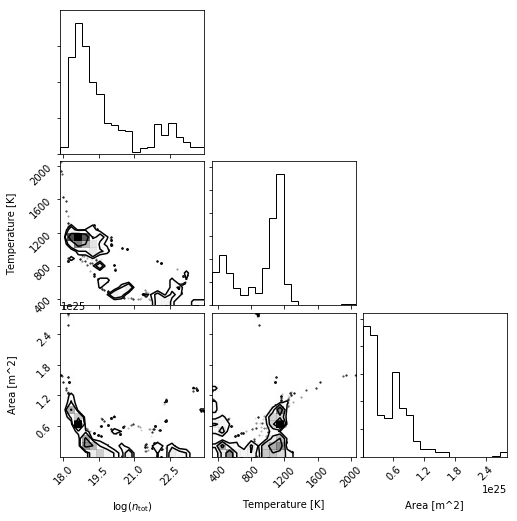

In [45]:
#Show results of model
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

print('Number of posterior samples is {}'.format(postsamples.shape[0]))

fig = corner.corner(postsamples, labels=[ r"$\log(n_\mathrm{tot})$",r"Temperature [K]","Area [m^2]"])